In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import pickle

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [5]:
df_train_dist = pd.read_csv(OUTPUT + '20190610_train_dist_cos_1000.csv')

In [6]:
def type_score(y_val, y_pred):
    return np.log(sum(np.abs(y_val- y_pred)) / len(y_val))

In [7]:
bond_types = df_train_dist['type'].unique()

In [8]:
mols = df_train_dist['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.8)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [31]:
models = []
scores = np.zeros([0])
for i, b in enumerate(bond_types):
    df_bond = df_train_dist.query('type == "{}"'.format(b))
    
    df_train = df_bond[df_bond['molecule_name'].isin(mols[pick_train])]
    y_train = df_train['scalar_coupling_constant'].values
    X_train = df_train[df_train.columns[6:]].values
    
    df_val = df_bond[df_bond['molecule_name'].isin(mols[pick_val])]
    y_val = df_val['scalar_coupling_constant'].values
    X_val = df_val[df_val.columns[6:]].values
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    params = {
            'task' : 'train',
            'boosting_type' : 'gbdt',
            'objective' : 'regression',
            'metric' : {'l2'},
            'num_leaves' : 31,
            'learning_rate' : 0.1,
            'feature_fraction' : 0.9,
            'bagging_fraction' : 0.8,
            'bagging_freq': 5,
        'verbose_eval':10, 
        'seed':0
    }
    
    gbm = lgb.train(params,
            lgb_train,
            num_boost_round=300,
            valid_sets=lgb_eval,
            early_stopping_rounds=10)
    
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
#     y_pred_train = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    score = type_score(y_val, y_pred)
    scores = np.hstack([scores, score])
    models.append(gbm)


[1]	valid_0's l2: 343.513
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 280.018
[3]	valid_0's l2: 228.98
[4]	valid_0's l2: 187.627
[5]	valid_0's l2: 153.738
[6]	valid_0's l2: 126.243
[7]	valid_0's l2: 103.746
[8]	valid_0's l2: 85.4949
[9]	valid_0's l2: 70.8365
[10]	valid_0's l2: 58.7379
[11]	valid_0's l2: 48.8595
[12]	valid_0's l2: 40.9241
[13]	valid_0's l2: 34.4416
[14]	valid_0's l2: 29.2136
[15]	valid_0's l2: 24.9767
[16]	valid_0's l2: 21.4962
[17]	valid_0's l2: 18.6543
[18]	valid_0's l2: 16.2231
[19]	valid_0's l2: 14.2168
[20]	valid_0's l2: 12.5624
[21]	valid_0's l2: 11.2261
[22]	valid_0's l2: 10.078
[23]	valid_0's l2: 9.14017
[24]	valid_0's l2: 8.36377
[25]	valid_0's l2: 7.69832
[26]	valid_0's l2: 7.18648
[27]	valid_0's l2: 6.73091
[28]	valid_0's l2: 6.34891
[29]	valid_0's l2: 6.01792
[30]	valid_0's l2: 5.72454
[31]	valid_0's l2: 5.46885
[32]	valid_0's l2: 5.27607
[33]	valid_0's l2: 5.09502
[34]	valid_0's l2: 4.94311
[35]	valid_0's l2: 4.81578
[36]

[297]	valid_0's l2: 2.6084
[298]	valid_0's l2: 2.60737
[299]	valid_0's l2: 2.60656
[300]	valid_0's l2: 2.60622
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 2.60622
[1]	valid_0's l2: 10.7701
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 8.96512
[3]	valid_0's l2: 7.45163
[4]	valid_0's l2: 6.24875
[5]	valid_0's l2: 5.27101
[6]	valid_0's l2: 4.46742
[7]	valid_0's l2: 3.77677
[8]	valid_0's l2: 3.22806
[9]	valid_0's l2: 2.75349
[10]	valid_0's l2: 2.37743
[11]	valid_0's l2: 2.0679
[12]	valid_0's l2: 1.81305
[13]	valid_0's l2: 1.59793
[14]	valid_0's l2: 1.42639
[15]	valid_0's l2: 1.28233
[16]	valid_0's l2: 1.16495
[17]	valid_0's l2: 1.06511
[18]	valid_0's l2: 0.982264
[19]	valid_0's l2: 0.906536
[20]	valid_0's l2: 0.847151
[21]	valid_0's l2: 0.79117
[22]	valid_0's l2: 0.744358
[23]	valid_0's l2: 0.704248
[24]	valid_0's l2: 0.674281
[25]	valid_0's l2: 0.649174
[26]	valid_0's l2: 0.62303
[27]	valid_0's l2: 0.602121
[28]	valid_0's l2: 0.580

[23]	valid_0's l2: 3.3744
[24]	valid_0's l2: 3.19189
[25]	valid_0's l2: 3.02394
[26]	valid_0's l2: 2.95255
[27]	valid_0's l2: 2.86186
[28]	valid_0's l2: 2.75899
[29]	valid_0's l2: 2.68622
[30]	valid_0's l2: 2.60164
[31]	valid_0's l2: 2.52379
[32]	valid_0's l2: 2.47592
[33]	valid_0's l2: 2.43321
[34]	valid_0's l2: 2.39692
[35]	valid_0's l2: 2.40151
[36]	valid_0's l2: 2.37327
[37]	valid_0's l2: 2.37138
[38]	valid_0's l2: 2.3412
[39]	valid_0's l2: 2.35969
[40]	valid_0's l2: 2.35655
[41]	valid_0's l2: 2.35558
[42]	valid_0's l2: 2.3379
[43]	valid_0's l2: 2.33917
[44]	valid_0's l2: 2.31091
[45]	valid_0's l2: 2.28449
[46]	valid_0's l2: 2.25985
[47]	valid_0's l2: 2.23511
[48]	valid_0's l2: 2.22569
[49]	valid_0's l2: 2.21652
[50]	valid_0's l2: 2.17817
[51]	valid_0's l2: 2.1663
[52]	valid_0's l2: 2.15723
[53]	valid_0's l2: 2.1424
[54]	valid_0's l2: 2.13599
[55]	valid_0's l2: 2.12594
[56]	valid_0's l2: 2.14008
[57]	valid_0's l2: 2.12812
[58]	valid_0's l2: 2.10999
[59]	valid_0's l2: 2.11302
[60]	v

[246]	valid_0's l2: 0.812652
[247]	valid_0's l2: 0.811686
[248]	valid_0's l2: 0.812018
[249]	valid_0's l2: 0.809574
[250]	valid_0's l2: 0.809586
[251]	valid_0's l2: 0.810961
[252]	valid_0's l2: 0.811792
[253]	valid_0's l2: 0.81118
[254]	valid_0's l2: 0.810031
[255]	valid_0's l2: 0.809098
[256]	valid_0's l2: 0.808478
[257]	valid_0's l2: 0.807397
[258]	valid_0's l2: 0.80659
[259]	valid_0's l2: 0.806707
[260]	valid_0's l2: 0.806125
[261]	valid_0's l2: 0.806075
[262]	valid_0's l2: 0.805647
[263]	valid_0's l2: 0.805543
[264]	valid_0's l2: 0.805959
[265]	valid_0's l2: 0.806037
[266]	valid_0's l2: 0.80486
[267]	valid_0's l2: 0.803802
[268]	valid_0's l2: 0.803181
[269]	valid_0's l2: 0.802336
[270]	valid_0's l2: 0.802158
[271]	valid_0's l2: 0.802329
[272]	valid_0's l2: 0.802232
[273]	valid_0's l2: 0.802104
[274]	valid_0's l2: 0.801749
[275]	valid_0's l2: 0.801094
[276]	valid_0's l2: 0.800083
[277]	valid_0's l2: 0.799466
[278]	valid_0's l2: 0.799331
[279]	valid_0's l2: 0.799236
[280]	valid_0's l

[235]	valid_0's l2: 0.890713
[236]	valid_0's l2: 0.889945
[237]	valid_0's l2: 0.890449
[238]	valid_0's l2: 0.890108
[239]	valid_0's l2: 0.889535
[240]	valid_0's l2: 0.889737
[241]	valid_0's l2: 0.889414
[242]	valid_0's l2: 0.88917
[243]	valid_0's l2: 0.888267
[244]	valid_0's l2: 0.887135
[245]	valid_0's l2: 0.885771
[246]	valid_0's l2: 0.885595
[247]	valid_0's l2: 0.884309
[248]	valid_0's l2: 0.884469
[249]	valid_0's l2: 0.884301
[250]	valid_0's l2: 0.884951
[251]	valid_0's l2: 0.883727
[252]	valid_0's l2: 0.882543
[253]	valid_0's l2: 0.882073
[254]	valid_0's l2: 0.881865
[255]	valid_0's l2: 0.88103
[256]	valid_0's l2: 0.880373
[257]	valid_0's l2: 0.88011
[258]	valid_0's l2: 0.879496
[259]	valid_0's l2: 0.879629
[260]	valid_0's l2: 0.879512
[261]	valid_0's l2: 0.877495
[262]	valid_0's l2: 0.876231
[263]	valid_0's l2: 0.874912
[264]	valid_0's l2: 0.873812
[265]	valid_0's l2: 0.872691
[266]	valid_0's l2: 0.87254
[267]	valid_0's l2: 0.869715
[268]	valid_0's l2: 0.870297
[269]	valid_0's l2

[34]	valid_0's l2: 3.86219
[35]	valid_0's l2: 3.83519
[36]	valid_0's l2: 3.80584
[37]	valid_0's l2: 3.78207
[38]	valid_0's l2: 3.75701
[39]	valid_0's l2: 3.73402
[40]	valid_0's l2: 3.70355
[41]	valid_0's l2: 3.68123
[42]	valid_0's l2: 3.66206
[43]	valid_0's l2: 3.64737
[44]	valid_0's l2: 3.63339
[45]	valid_0's l2: 3.60643
[46]	valid_0's l2: 3.59437
[47]	valid_0's l2: 3.58001
[48]	valid_0's l2: 3.54984
[49]	valid_0's l2: 3.53251
[50]	valid_0's l2: 3.51996
[51]	valid_0's l2: 3.50635
[52]	valid_0's l2: 3.49365
[53]	valid_0's l2: 3.4825
[54]	valid_0's l2: 3.47438
[55]	valid_0's l2: 3.45284
[56]	valid_0's l2: 3.43605
[57]	valid_0's l2: 3.42805
[58]	valid_0's l2: 3.42269
[59]	valid_0's l2: 3.40446
[60]	valid_0's l2: 3.3931
[61]	valid_0's l2: 3.38931
[62]	valid_0's l2: 3.38204
[63]	valid_0's l2: 3.37782
[64]	valid_0's l2: 3.3663
[65]	valid_0's l2: 3.34877
[66]	valid_0's l2: 3.33421
[67]	valid_0's l2: 3.32097
[68]	valid_0's l2: 3.3107
[69]	valid_0's l2: 3.29636
[70]	valid_0's l2: 3.27237
[71]	

[26]	valid_0's l2: 0.636937
[27]	valid_0's l2: 0.630019
[28]	valid_0's l2: 0.617743
[29]	valid_0's l2: 0.607719
[30]	valid_0's l2: 0.603211
[31]	valid_0's l2: 0.596071
[32]	valid_0's l2: 0.591613
[33]	valid_0's l2: 0.586878
[34]	valid_0's l2: 0.579878
[35]	valid_0's l2: 0.575305
[36]	valid_0's l2: 0.565962
[37]	valid_0's l2: 0.563926
[38]	valid_0's l2: 0.560368
[39]	valid_0's l2: 0.558577
[40]	valid_0's l2: 0.557087
[41]	valid_0's l2: 0.557736
[42]	valid_0's l2: 0.56094
[43]	valid_0's l2: 0.560576
[44]	valid_0's l2: 0.556043
[45]	valid_0's l2: 0.558735
[46]	valid_0's l2: 0.556408
[47]	valid_0's l2: 0.55328
[48]	valid_0's l2: 0.551354
[49]	valid_0's l2: 0.549653
[50]	valid_0's l2: 0.547995
[51]	valid_0's l2: 0.54752
[52]	valid_0's l2: 0.546648
[53]	valid_0's l2: 0.54625
[54]	valid_0's l2: 0.54298
[55]	valid_0's l2: 0.54389
[56]	valid_0's l2: 0.541576
[57]	valid_0's l2: 0.540676
[58]	valid_0's l2: 0.540103
[59]	valid_0's l2: 0.539762
[60]	valid_0's l2: 0.541082
[61]	valid_0's l2: 0.54028

In [32]:
print('type score:', scores)
print('total score:', scores.mean())

type score: [ 0.08294266 -1.11509205 -0.03600214 -0.58307473 -0.61131158  0.39068907
  0.09762699 -0.81742628]
total score: -0.3239560077993917


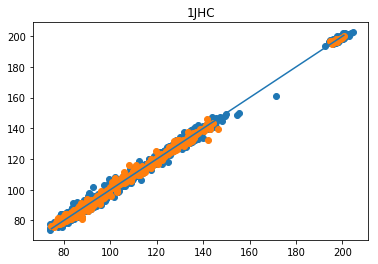

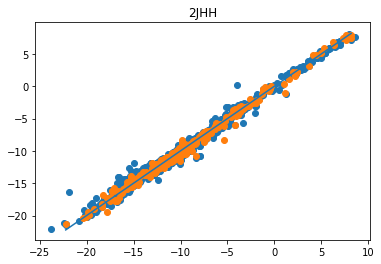

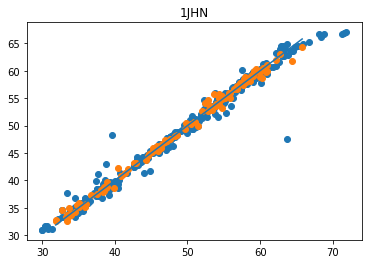

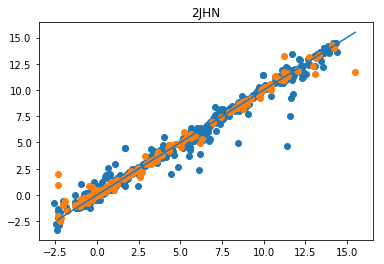

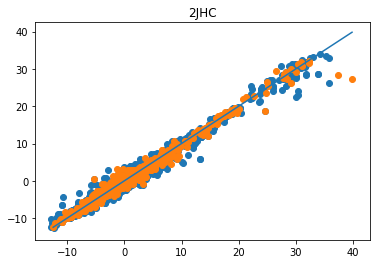

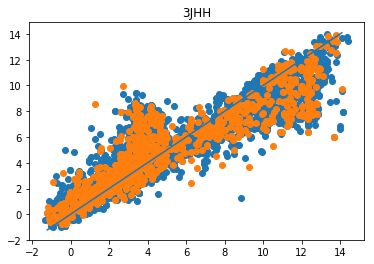

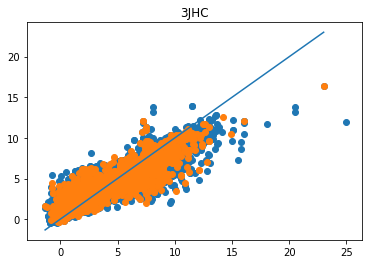

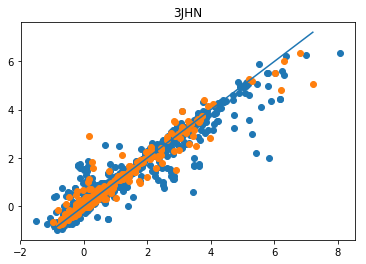

In [33]:
for i, b in enumerate(bond_types):
    df = df_train_dist.query('type == "{}"'.format(b))
    y = df['scalar_coupling_constant'].values
    X = df[df.columns[6:]].values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    model = models[i]
    
    y_pred = model.predict(X_val, num_iteration=gbm.best_iteration)
    y_pred_train = model.predict(X_train, num_iteration=gbm.best_iteration)
    plt.scatter(y_train, y_pred_train)
    plt.scatter(y_val, y_pred)
    plt.title('{}'.format(b))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
    plt.show()

In [34]:
with open(OUTPUT + '20190612_champs_models_lgb.pickle', 'wb') as f:
    pickle.dump(models, f)